## SIR-PriorCVAE samples

This notebook helps in visualizing the samples of trained SIR-PriorCVAE decoder samples

**This notebook generates Fig. A26**

In [1]:
import os
import random
import yaml

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn
import numpyro.distributions as npdist
import tikzplotlib

from priorCVAE.datasets import SIRDataset
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples

import jax.config as config
config.update("jax_enable_x64", True)

random.seed(153)


In [2]:
output_dir = "../../outputs/01-09-49/"
n_trajectories = 20
n_plots = 4

z_init = jnp.array([762, 1.0, 0.0])
num_days = 14
beta_prior = npdist.TruncatedNormal(loc=2, scale=1, low=0.)
gamma_prior = npdist.TruncatedNormal(loc=0.4, scale=0.5, low=0.)

last_layer_activation = nn.sigmoid  # None

export_tex = True
output_tex_path = r"../../../../../papers/priorcvae/figures/SIR/"

## Loading Trained Decoder

In [3]:
cfg_path = os.path.join(output_dir, ".hydra", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]
conditional = cfg_data["conditional"]
dec_activation_fn = cfg_data["dec_activation"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

In [4]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

In [5]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [6]:
print(f"Latent dim: {latent_dim}, Conditional : {conditional}")

Latent dim: 6, Conditional : True


## Plot samples

In [7]:
sir_dataset = SIRDataset(z_init, num_days)

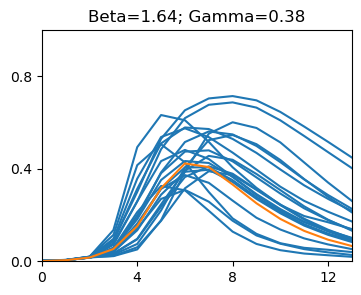

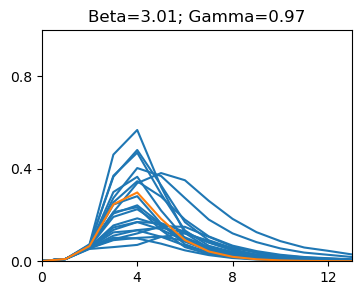

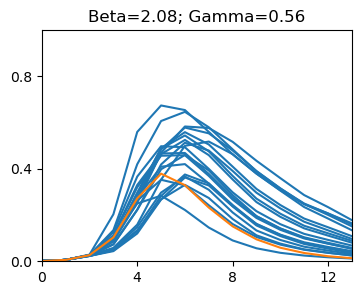

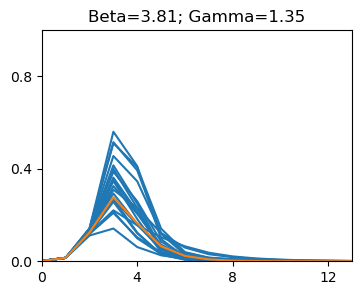

In [8]:
for i in range(n_plots):
    
    key1, key2 = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)), 2)
    
    beta = beta_prior.sample(key=key1)
    gamma = gamma_prior.sample(key=key1)
    
    c = None
    if conditional:
        c = jnp.repeat(jnp.array([beta, gamma])[None, ...], n_trajectories, axis=0)
        
    key = jax.random.PRNGKey(random.randint(0, 9999))
    sir_dataset.beta = beta
    sir_dataset.gamma = gamma
    _, true_samples, _ = sir_dataset.simulatedata(n_samples=1)
    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                               c=c, num_samples=n_trajectories, latent_dim=latent_dim)
    
    if last_layer_activation is not None:
        vae_samples = last_layer_activation(vae_samples)
    
    fig, axs = plt.subplots(1, 1, figsize=(4, 3))
    
    for v in vae_samples:
        plt.plot(v, c="tab:blue")

    for s in true_samples:
        plt.plot(s, c="tab:orange")
    
    beta_viz = round(beta.item(), 2)
    gamma_viz = round(gamma.item(), 2)
    
    plt.xlim([0, 13])
    plt.ylim([0, 1])
    
    plt.yticks([])
    plt.xticks([])
    
    if export_tex:
        file_name = f"SIR_samples_{beta:.2f}_{gamma:.2f}".replace(".", "_") + ".tex"
        tikzplotlib.save(os.path.join(output_tex_path, file_name), 
                         figurewidth='\\figurewidth', figureheight='\\figureheight')
        
    plt.yticks([0, 0.4, 0.8])
    plt.xticks([0, 4, 8, 12])
    
    plt.title(f"Beta={beta_viz}; Gamma={gamma_viz}")
    plt.show()